In [1]:
# load all the necessary modules
import numpy as np

# for pymc3
import pymc3 as pm
import arviz as az
from theano import tensor as tt

# plotting results
from matplotlib import pyplot as plt
import seaborn as sns

## for generating nb samples
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tf.disable_v2_behavior()

from collections import Counter
import operator

import os

Instructions for updating:
non-resource variables are not supported in the long term


## Necessary functions

In [2]:
def return_scenation(scenario_number):
    
    if scenario_number == 1:
        # setting 1: difficult to infer
        centers               = [0.2,0.4,0.5,0.7,0.9]
        bias                  = 6.4
        mean_params_true      = {'l':0.89,
                                 'weights':[bias,2.2,0.76,-4.5,-5.1,-3.4],# first is bias
                                 'centers':centers}
        phi_true              =  7.7
        expression_type       = "many_zeroes"
        return mean_params_true,phi_true,expression_type
    elif scenario_number == 2:
        # setting 2: neutral regulation
        centers               = [0.15,0.23,0.4,0.67,0.7,0.8]
        bias                  = -2.4
        mean_params_true      = {'l':2.89,
                                 'weights':[bias,-0.2,0.76,1.1,1.5,2.1,-1.4],# first is bias
                                 'centers':centers}
        phi_true              =  3.7
        expression_type       = "neutral"
        return mean_params_true,phi_true,expression_type
    elif scenario_number == 3:
        # setting 3: upregulation
        centers               = [0.15,0.23,0.4,0.67,0.7,0.8]
        bias                  = 2.45
        mean_params_true      = {'l':0.59,
                                 'weights':[bias,-1.0,-0.76,0.1,0.5,1.1,1.4],# first is bias
                                 'centers':centers}
        phi_true              =  23.7
        expression_type       = "upregulated"
        return mean_params_true,phi_true,expression_type
    elif scenario_number == 4:
        # setting 4: donwregulated
        centers               = [0.15,0.23,0.4,0.67,0.7,0.8]
        bias                  = 2.45
        mean_params_true      = {'l':0.59,
                                 'weights':[bias,1.2,0.46,-0.1,-0.9,-1.1,-1.4],# first is bias
                                 'centers':centers}
        #phi_true              =  23.7
        phi_true              =  3.7
        expression_type       = 'downregulated'
        return mean_params_true,phi_true,expression_type
    else:
        print("Wrong scenario number")
        return None,None,None
    
def generate_nb_samples(pst,mean_params,phi_true,seed=1):
    
    # inline function
    rbf   = lambda x,c,l: np.exp(-(x-c)**2/(2*l**2))
  
    # concstruct mean
    l             = mean_params['l']
    weights       = mean_params['weights'] # including weight for bias
    centers       = mean_params['centers']
    ones          = np.ones((1,pst.shape[0]))
    temp          = np.array([rbf(pst,c,l) for c in centers])
    temp          = np.vstack([ones,temp]).T
    true_mean     = np.exp(np.dot(temp,weights))
    
    
    # now we need to convert it to p and n
    r       = phi_true
    logit_p = np.log(true_mean) - np.log(phi_true) # will become a vector
    
    # convert to tensors
    r       = tf.constant(r,dtype=tf.float32)              
    logit_p = tf.constant(logit_p,dtype=tf.float32)   

    # instantiate Negative Binomial from tensorflow
    NB_dist = tfp.distributions.NegativeBinomial(r, logits = logit_p)
    samples = NB_dist.sample(seed=seed)
  
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        vSamples = samples.eval()
    sess.close()
    
    return vSamples.flatten()

def rbf_construction(x,c,l):
        return np.exp(-(x-c)**2/(2*l**2))

def sample_points(curve_params,t):
    l              = curve_params['l']
    weights        = curve_params['weights'] # including weight for bias
    centers        = curve_params['centers']
    
    ones           = np.ones((1,t.shape[0]))
    temp           = np.array([rbf_construction(t,c,l) for c in centers])
    temp           = np.vstack([ones,temp]).T
    result         = np.exp(np.dot(temp,weights)) # this should be the curve evaluated at points t
    return result

def compute_design_matrix(x,c,l):
    x    = x[:,np.newaxis]
    c    = np.array(c)[np.newaxis,:]
    
    # detailed calculations
    crossdifference = x-c
    #print("Cross difference shape:",crossdifference.shape)
    out  = np.exp(-(crossdifference)**2/(2*l**2))
    
    #print("output without intercept:",out.shape)
   
    ones = np.ones((x.shape[0],1))
    out  = np.hstack([ones,out])
    
    #print("output with intercept:",out.shape)
    
    return out

### returns probabilities
def stick_breaking(v):
    cumprod = tt.extra_ops.cumprod(1. - v,axis=1)[:-1,:]
    ones    = tt.ones_like(v[:1,:])
    concat  = tt.concatenate([ones,cumprod],axis=0)
    breaks  = v * concat
    probs   = breaks/tt.sum(breaks,axis=0)
    return probs

### returns probabilities
def stick_breaking_for_array(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    retVal = beta * portion_remaining
    retVal = retVal/tt.sum(retVal)
    return retVal

## Generate artificial data
I will generate 40 observations/genes/samples. 20 will come from upregulated scenario, 20 will come from downregulated scenario. Essentially this means that a particular Negative Binomial (NB) distribution (with some parameters that define mean expression and overdispersion) sampling routine will be called 20 times with different random seeds.
Effectively, I am using 2 different NB distributions (this is what I call a "scenario") and sample 20 times from each.

In [3]:
T       = 200
n_times = 20
samples = []
pst     = np.linspace(start=0,stop=1,num=T)

# first the upregulated scenario
mean_params_true,phi_true,expression_type = return_scenation(3) #3
mean_params_upreg = mean_params_true
phi_upreg         = phi_true

for i in range(n_times):
    samples.append(generate_nb_samples(pst,mean_params_true,phi_true,seed=i))

    
# second the downregulated scenario
mean_params_true,phi_true,expression_type = return_scenation(4)
mean_params_downreg = mean_params_true
phi_downreg         = phi_true

for i in range(n_times):
    samples.append(generate_nb_samples(pst,mean_params_true,phi_true,seed=i))



# convert to numpy
samples = np.array(samples)
#samples = samples.T

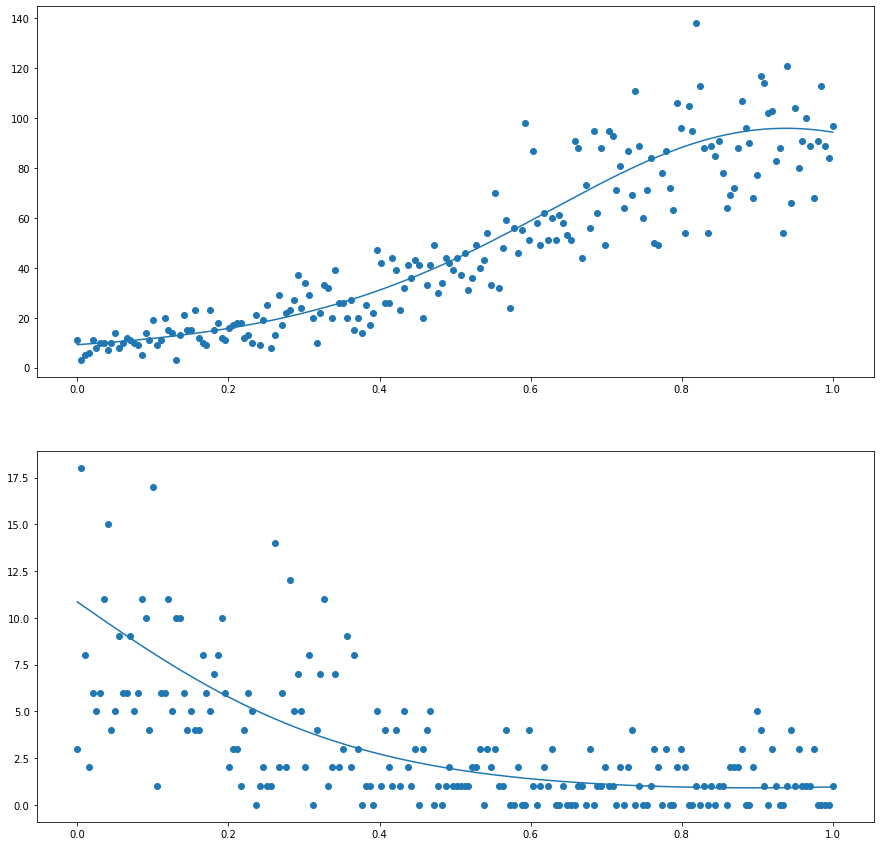

In [55]:
## examples of genes
fix,axs  = plt.subplots(2,1,figsize=(15,15))
gene_ids = [0,35]
for i,gene in enumerate(gene_ids):
    if gene < n_times:
        mean_params_true = mean_params_upreg
    else:
        mean_params_true = mean_params_downreg
    true_mean = sample_points(mean_params_true,pst)
    axs[i].scatter(pst,samples[gene,:])
    axs[i].plot(pst,true_mean)
plt.show()
plt.close()

## Compute design matrix
I need to precompute design matrix where each row is (1, f1, f2, f3 ...) evaluated at each pseudotime point.
f1,f2,f3... are fixed RBFs.

In [13]:
centers_mu         = [0.1,0.4,0.7] # fix the RBF centers
l_mu               = 0.5           # fix the RBF lengthscale
DM_mean            = compute_design_matrix(pst,np.array(centers_mu),l_mu)

K_mean             = len(centers_mu)+1 # +1 for intercept

In [14]:
print("Design matrix shape:",DM_mean.shape)
print(DM_mean)

Design matrix shape: (200, 4)
[[1.         0.98019867 0.72614904 0.3753111 ]
 [1.         0.9821213  0.73197399 0.38060996]
 [1.         0.98394831 0.73777114 0.38594465]
 [1.         0.98567915 0.7435391  0.39131458]
 [1.         0.9873133  0.74927646 0.39671916]
 [1.         0.98885028 0.75498184 0.40215776]
 [1.         0.99028962 0.76065382 0.40762974]
 [1.         0.99163088 0.76629101 0.41313444]
 [1.         0.99287367 0.771892   0.41867119]
 [1.         0.99401761 0.7774554  0.42423928]
 [1.         0.99506236 0.78297981 0.42983801]
 [1.         0.99600759 0.78846383 0.43546664]
 [1.         0.99685302 0.79390606 0.44112442]
 [1.         0.9975984  0.79930512 0.44681057]
 [1.         0.99824351 0.80465962 0.4525243 ]
 [1.         0.99878814 0.80996817 0.45826481]
 [1.         0.99923213 0.81522939 0.46403127]
 [1.         0.99957535 0.82044191 0.46982283]
 [1.         0.9998177  0.82560436 0.47563863]
 [1.         0.99995909 0.83071538 0.48147779]
 [1.         0.99999949 0.8357

In [15]:
# mean hyperparameters
J_mean  = 30 # possible clusters for each RBF cooefficient to come from
J_phi   = 30 # possible clusters for phi to come from

N,P     = samples.shape
print("Samples shape                                                        :",samples.shape)
print("Number of observations/genes                                         :",N)
print("Number of features/cells                                             :",P)

print("Number of possible clusters for parameter phi                        :",J_phi)
print("Number of possible clusters for each RBF weight (including intercept):",J_phi)

print("Number of RBFs for parameter mu                                      :",K_mean)


r_k  = np.ones((K_mean,J_mean)) * 0.5
b_k  = np.ones((K_mean,J_mean)) * 2

Samples shape                                                        : (40, 200)
Number of observations/genes                                         : 40
Number of features/cells                                             : 200
Number of possible clusters for parameter phi                        : 30
Number of possible clusters for each RBF weight (including intercept): 30
Number of RBFs for parameter mu                                      : 4


## Model specification
In the comments I described what is done and what I want to achieve with each particular step (whether it is a sampling step or transformation step or algebraic operation step).
Main insiparation for the model: https://arxiv.org/pdf/1904.11758.pdf
I am trying to re-do equations 6,7 into a mixture model (if it is possible).

In [16]:
# some starting points
test_point_betas_for_DP = np.ones((J_mean,K_mean))*0.2
testval_alpha_K         = np.ones((K_mean,))*3

with pm.Model() as model:
    ################################################## I. MU PART ################################
    
    ### prior for the concentraion : eq.8
    ### only mu (see likelihod) parameter is a linear combination of RBFs in this model (once I am sure it is working, it will be easy to extend for parameter phi)
    ### log_mu = b0*1 + b1 * f1 + b2* f2 + ...  (need not to forget to exponentiate later)
    ### we have K_mean (:= # of RBFs plus an offset) terms in the linear combination
    ### values (1, f1, f2, ...) come from Design Matrix which is computed above
    ### each coefficient b(i) (total # of coefficients is K_mean) comes from a Dirichlet Process
    ### we need K_mean independent concentration priors
    alpha_K           = pm.Gamma('alpha_K', 1., 1., shape = K_mean, testval = testval_alpha_K)
    
    

    ##### samples from beta (1,alpha) : eq.8
    ##### we need to sample J_mean (:= maximum number of clusters for a particular DP) samples for each of K_mean DP
    betas_for_mu      = pm.Beta('betas_for_DP_for_coefficients',
                                1.0,
                                alpha_K,
                                shape   = (J_mean,K_mean),
                                testval = test_point_betas_for_DP
                                )
    # stack of 4 independent 15-component weight arrays: in variable terms shape=(K_mean,J_mean)
    #w_mix_rbfs              = pm.Deterministic('w_for_mu',
    #                                            stick_breaking(betas_for_mu).T
    #                                          ) 
    
    ### eq.8 getting p(jk)
    w_mix_rbfs        = pm.Deterministic("w_rbfs",
                                         stick_breaking(betas_for_mu).T)
    
    
    #### now working with eq. 6,7
    #### define components: mu(jk) and s(jk)
    mu_jk  = pm.Normal("mu_jk",mu=0.0,tau=r_k,shape=(K_mean,J_mean))
    s_jk   = pm.Gamma("s_jk",alpha=1.0,beta=b_k,shape=(K_mean,J_mean))
    
    ####### still working with eq. 7
    ####### this is following the logic from: https://docs.pymc.io/api/distributions/mixture.html (about stacking the mixtures)
    # create a mixture and sample N times from it
    coef_rbfs               = pm.Mixture("coef_rbfs",w_mix_rbfs,
                                         comp_dists = pm.Normal.dist(mu=mu_jk,tau=s_jk,shape=(N,K_mean,J_mean)),
                                         shape = (N,K_mean)
                                        )
    ### create a linear combination and exponentiate it
    mu_NB                   = pm.Deterministic("mu_NB",
                                              tt.exp(tt.dot(coef_rbfs,DM_mean.T))
                                              )
    
    
    ################################################## II. PHI(ALPHA) PART ################################
    ### concentration prior for DP
    alpha_for_phi          = pm.Gamma('alpha_for_phi', 1., 1.,testval = 0.6)
    
    
    ### sample J_phi (:= number of possible components for parameter phi) values from beta distribution
    samples_from_beta_phi  = pm.Beta('betas_for_DP_for_phi',
                                      1.0,
                                      alpha_for_phi,
                                      shape   = J_phi,
                                      testval = 0.9
                                     )
    
    ### use stick-breaking function on samples from the previous step
    ### output is a weight array: all weights are from simplex
    w_phi                  = pm.Deterministic("w_phi",
                                              stick_breaking_for_array(samples_from_beta_phi))
    
     
    prior_a    = pm.Gamma('prior_a',1.0,1.0,shape = J_phi)
    prior_b    = pm.Gamma('prior_b',1.0,1.0,shape = J_phi)
    
    
    ### create a mixture for parameter phi -> sample N samples from a mixture
    phi_mix    = pm.Mixture('phi_mix',w_phi,
                            pm.Gamma.dist(prior_a,prior_b,shape=J_phi),
                            shape = N
                            )
    # expand
    phi_NB    = pm.Deterministic("phi_NB",
                                 (tt.ones([P,N]) * phi_mix).T)
    
    # likelihoood
    y          = pm.NegativeBinomial("y",
                                     mu       = mu_NB, 
                                     alpha    = phi_NB,
                                     observed = samples)
    

## Check if model works
Run some tests suggested by PyMC3.

In [17]:
# just checking if model works
for RV in model.basic_RVs:
    print(f"RV name:{RV.name}, \n \t\t logP of RV at test point: {RV.logp(model.test_point)}")
    print('-'*10)

RV name:alpha_K_log__, 
 		 logP of RV at test point: -7.605550845327563
----------
RV name:betas_for_DP_for_coefficients_logodds__, 
 		 logP of RV at test point: -141.63075332503465
----------
RV name:mu_jk, 
 		 logP of RV at test point: -151.8614548181574
----------
RV name:s_jk_log__, 
 		 logP of RV at test point: -120.0
----------
RV name:coef_rbfs, 
 		 logP of RV at test point: -202.4819397575436
----------
RV name:alpha_for_phi_log__, 
 		 logP of RV at test point: -1.1108256237659906
----------
RV name:betas_for_DP_for_phi_logodds__, 
 		 logP of RV at test point: -59.93211585660737
----------
RV name:prior_a_log__, 
 		 logP of RV at test point: -30.0
----------
RV name:prior_b_log__, 
 		 logP of RV at test point: -30.0
----------
RV name:phi_mix, 
 		 logP of RV at test point: -39.99999999999999
----------


INFO (theano.gof.compilelock): Refreshing lock /Users/evgeniilobzaev/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock


RV name:y, 
 		 logP of RV at test point: -150828.82648985568
----------


In [18]:
print(model.test_point)

{'alpha_K_log__': array([1.09861229, 1.09861229, 1.09861229, 1.09861229]), 'betas_for_DP_for_coefficients_logodds__': array([[-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.38629436, -1.38629436, -1.38629436],
       [-1.38629436, -1.3862

## Plot graphical model

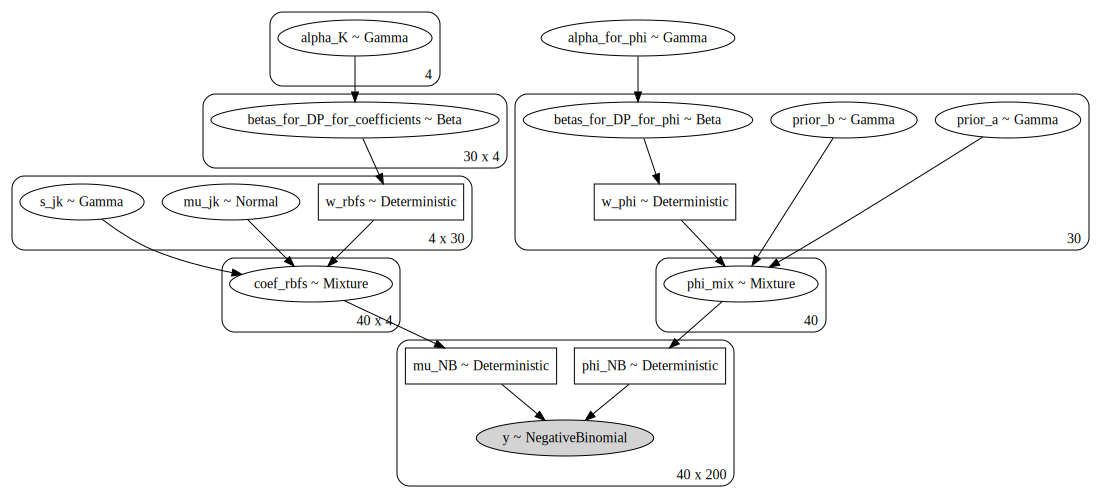

In [19]:
## graphical model
pm.model_to_graphviz(model)

In [20]:
n_samples = 3000
burnin    = 500
with model:
    trace = pm.sample(n_samples, 
                      tune        = burnin, 
                      chains      = 1,
                      random_seed = 10,
                      init        = 'adapt_diag', #'adapt_diag', # "advi" init seems not to be working
                      progressbar = True,
                      nuts_kwargs = {"target_accept":0.9}
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [phi_mix, prior_b, prior_a, betas_for_DP_for_phi, alpha_for_phi, coef_rbfs, s_jk, mu_jk, betas_for_DP_for_coefficients, alpha_K]
Sampling chain 0, 2,949 divergences: 100%|██████████| 3500/3500 [12:11<00:00,  4.79it/s]
There were 2950 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [21]:
# extract mu and phi
mus  = trace["mu_NB"][burnin:n_samples,:,:]
phis = trace["phi_NB"][burnin:n_samples,:,:]

print("shape of mus :",mus.shape)
print("shape of phis:",phis.shape)

shape of mus : (2500, 40, 200)
shape of phis: (2500, 40, 200)


## Plot some fit
Plot randomly 3 genes from upregulated category and 3 genes from downregulated category.

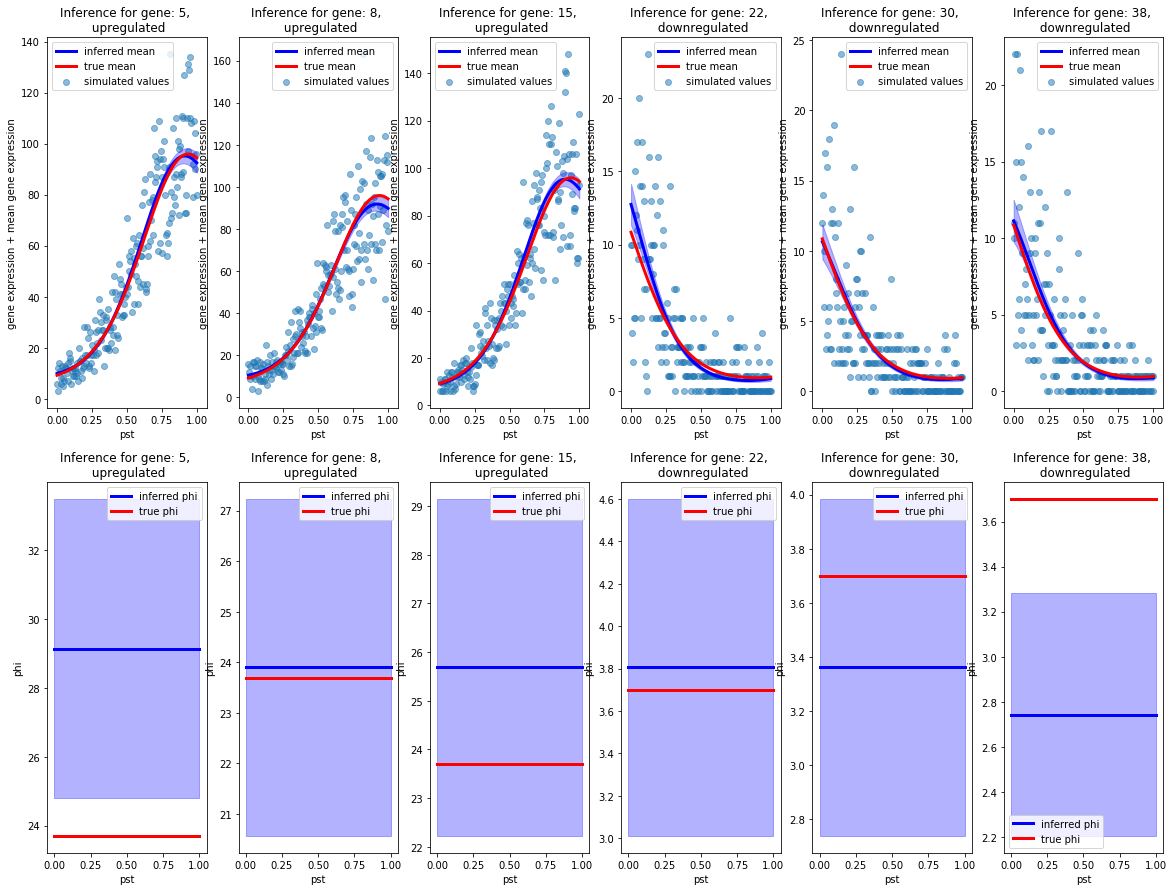

In [22]:
genes   = [5,8,15,22,30,38] 
# create plots
fig,axs = plt.subplots(2,len(genes),figsize=(20,15))
for i, gene in enumerate(genes):
    
    samples_gene = samples[gene,:]
    if gene <n_times:
        mean_params_true = mean_params_upreg
        phi_true         = phi_upreg
        lbl_             = "upregulated"
    else:
        mean_params_true = mean_params_downreg
        phi_true         = phi_downreg  
        lbl_             = "downregulated"

    # obtain true values
    true_mean    = sample_points(mean_params_true,pst)
    true_phi     = np.ones_like(true_mean) * phi_true

    # obtain sampled values
    mean_        = np.mean(mus[:,gene,:],axis=0)
    std_mean_    = np.std(mus[:,gene,:],axis=0)
    
    phi_         = np.mean(phis[:,gene,:],axis=0)
    std_phi_     = np.std(phis[:,gene,:],axis=0)


    axs[0,i].scatter(pst,samples_gene,alpha=0.50,label="simulated values")
    axs[0,i].plot(pst,mean_,'b', lw=3, zorder=9, label="inferred mean")
    axs[0,i].fill_between(pst, mean_ - std_mean_, mean_ + std_mean_,
                                     alpha=0.3, color='b')
    axs[0,i].plot(pst, true_mean, 'r', lw=3, zorder=9, label="true mean")
    axs[0,i].set_xlabel("pst")
    axs[0,i].set_ylabel("gene expression + mean gene expression")
    axs[0,i].set_title(f"Inference for gene: {gene}, \n {lbl_}")
    axs[0,i].legend()


    axs[1,i].plot(pst,phi_,'b', lw=3, zorder=9, label="inferred phi")
    axs[1,i].fill_between(pst, phi_ - std_phi_, phi_ + std_phi_,
                                     alpha=0.3, color='b')
    axs[1,i].plot(pst, true_phi, 'r', lw=3, zorder=9, label="true phi")
    axs[1,i].set_xlabel("pst")
    axs[1,i].set_ylabel("phi")
    axs[1,i].set_title(f"Inference for gene: {gene}, \n {lbl_}")
    axs[1,i].legend()



plt.show()
plt.close()

## INVESTIGATE MIXTURE COMPOSITION FOR PARAMETER $\phi$
Seems like 2 clusters were identified.

(2500, 30)


Text(0, 0.5, 'Posterior expected mixture weight for phi parameter')

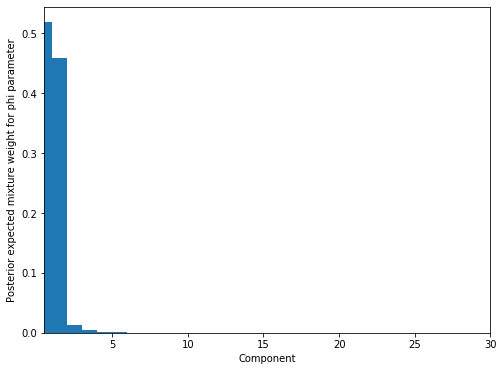

In [23]:
weights_phi = trace["w_phi"][burnin:n_samples,:]
print(weights_phi.shape)

# check how many cluster were identified for phi
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(J_phi) + 1
ax.bar(plot_w - 0.5, weights_phi.mean(axis=0), width=1., lw=0)
ax.set_xlim(0.5, J_phi)
ax.set_xlabel('Component')
ax.set_ylabel('Posterior expected mixture weight for phi parameter') # should be close to 2

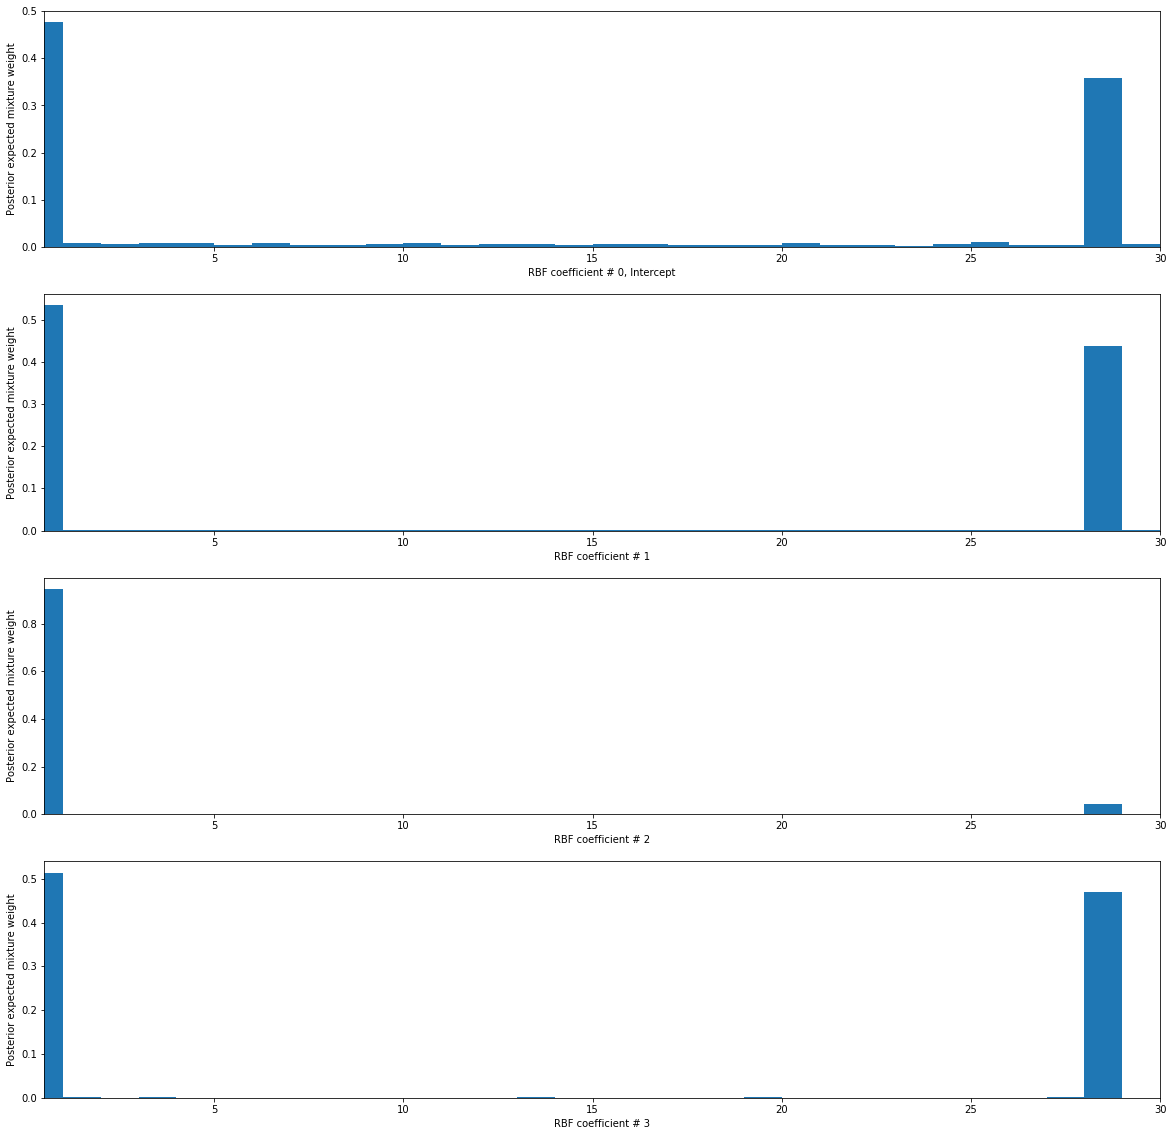

In [24]:
# lets take a look at weights for RBFS
weights_rbf_coef = trace["w_rbfs"]
d = {}
for i in range(K_mean):
    d[i] = weights_rbf_coef[burnin:n_samples,i,:]

plot_w_mean = np.arange(J_mean) + 1
fig, axs = plt.subplots(K_mean,1,figsize=(20, 20))
for i in range(K_mean):
    weights_rbf_current = d[i]
    axs[i].bar(plot_w - 0.5, weights_rbf_current.mean(axis=0), width=1., lw=0)
    axs[i].set_xlim(0.5, J_phi)
    i_label = f"{i}"
    if i == 0: i_label = "0, Intercept"
    axs[i].set_xlabel(f'RBF coefficient # {i_label}')
    axs[i].set_ylabel(f'Posterior expected mixture weight')
plt.show()
plt.close()

## Trying to do VI
Model checks are done here as well

In [50]:
model.check_test_point()

alpha_K_log__                                  -7.61
betas_for_DP_for_coefficients_logodds__      -141.63
mu_jk                                        -151.86
s_jk_log__                                   -120.00
coef_rbfs                                    -202.48
alpha_for_phi_log__                            -1.11
betas_for_DP_for_phi_logodds__                -59.93
prior_a_log__                                 -30.00
prior_b_log__                                 -30.00
phi_mix                                       -40.00
y                                         -150828.83
Name: Log-probability of test_point, dtype: float64

In [51]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    advi = pm.ADVI()

In [52]:
advi.approx

In [53]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

In [54]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [55]:
### check the values
mu  = advi.approx.params[0]
rho = advi.approx.params[1]

print("mu:",mu.eval())
print('-'*50)
print("rho:",rho.eval())

mu: [-1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.3862943

In [57]:
## set values to 0
#mu.set_value(np.zeros(mu.eval().shape))
#rho.set_value(np.zeros(rho.eval().shape))

# set value to some number
mu.set_value(np.ones(mu.eval().shape) * 0.3)
rho.set_value(np.ones(rho.eval().shape) * 0.5)

print("mu:",mu.eval())
print('-'*10)
print("rho:",rho.eval())

mu: [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.

In [58]:
approx = advi.fit(20000, callbacks=[tracker])

  0%|          | 0/20000 [00:00<?, ?it/s]


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[0] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[1] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[2] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[3] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[4] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[5] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[6] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[7] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[8] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[9] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[10] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[11] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[12] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[13] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[14] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[15] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[16] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[17] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[18] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[19] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[20] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[21] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[22] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[23] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[24] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[25] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[26] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[27] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[28] is NaN.
The current approximation of RV `betas_for_DP_for_phi_logodds__`.ravel()[29] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters